In [1]:
import pandas as pd
import numpy as np
import modeling_functions as mf
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
# Prices
print("Loading prices data...")
url = 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw'
prices = pd.read_csv("prices.csv", parse_dates=True, index_col=0)
print("✓ Loaded prices")

Loading prices data...
✓ Loaded prices


In [2]:
prices.head(10)

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
2018-01-01 06:00:00,BTC,13781.2,13849.4,13747.0,13747.0,26.133538
2018-01-01 07:00:00,BTC,14108.4,14224.0,14099.0,14168.7,12.534892
2018-01-01 08:00:00,BTC,13950.1,14120.4,13901.1,13922.1,9.495752
2018-01-01 09:00:00,BTC,13742.7,13884.0,13742.7,13785.0,6.781434


In [3]:
# Calculate Simple Moving Averages: 3-period and 12-period
sma_df = pd.DataFrame(index=prices.index)
# Lag the 'close' before calculating rolling means to avoid lookahead bias
lagged_close = prices['close'].shift(1)
sma_df['close'] = prices['close']
# Calculate lagged SMA_3 and SMA_12
sma_df['SMA_3'] = lagged_close.rolling(window=6).mean()
sma_df['SMA_12'] = lagged_close.rolling(window=24).mean()

# Compute the difference between SMA_3 and SMA_12
sma_df['MA_diff'] = sma_df['SMA_3'] - sma_df['SMA_12']

# Shift MA_diff to detect crossovers
sma_df['MA_diff_shift'] = sma_df['MA_diff'].shift(1)

# Define crossover signal: 1 for golden cross, -1 for death cross
def crossover(row):
    if row['MA_diff'] > 0 and row['MA_diff_shift'] <= 0:
        return 1   # golden cross (SMA_3 crosses above SMA_12)
    elif row['MA_diff'] < 0 and row['MA_diff_shift'] >= 0:
        return -1  # death cross (SMA_3 crosses below SMA_12)
    else:
        return 0   # no crossover

# Apply crossover detection
sma_df['SMA_signal_raw'] = sma_df.apply(crossover, axis=1)

# Forward-fill signal: carry previous signal if current is 0
sma_df['SMA_signal'] = sma_df['SMA_signal_raw'].replace(to_replace=0, method='ffill')
# Calculate rolling 6h standard deviation of lagged close (as before)
sma_df['volatility_6h'] = lagged_close.rolling(window=6).std()
# Perform rolling z-score normalization over a 48-hour window
vol_mean = sma_df['volatility_6h'].rolling(window=48).mean()
vol_std = sma_df['volatility_6h'].rolling(window=48).std()
sma_df['volatility_6h_signal'] = (sma_df['volatility_6h'] - vol_mean) / vol_std

# Update final_df to include the standardized volatility
final_df = sma_df[['close', 'SMA_3', 'SMA_12', 'SMA_signal', 'volatility_6h_signal']]
final_df

,close,SMA_3,SMA_12,SMA_signal,volatility_6h_signal
date,,,,,
2018-01-01 01:00:00,13680.0,NaN,NaN,0,NaN
2018-01-01 02:00:00,13514.0,NaN,NaN,0,NaN
2018-01-01 03:00:00,13560.2,NaN,NaN,0,NaN
2018-01-01 04:00:00,13667.4,NaN,NaN,0,NaN
2018-01-01 05:00:00,13765.0,NaN,NaN,0,NaN
...,...,...,...,...,...
2024-03-20 12:00:00,63701.9,62644.800000,63151.387500,-1,-0.215392
2024-03-20 13:00:00,63764.1,62971.450000,63158.308333,-1,-0.524426
2024-03-20 14:00:00,63865.9,63247.100000,63173.779167,1,-1.123813


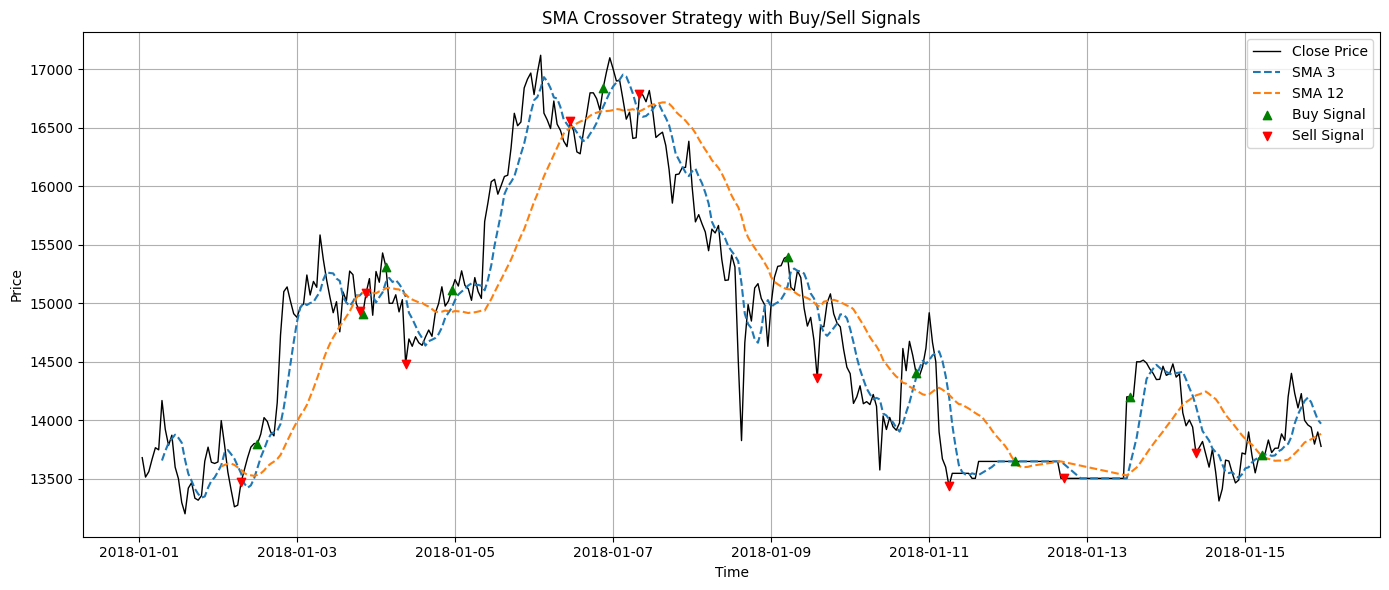

In [5]:
import matplotlib.pyplot as plt
# Restrict the date range
start_date = '2018-01-01'
end_date = '2018-01-15'
final_df_limited = final_df.loc[start_date:end_date]
# Identify points where signal changes (crossovers)
signal_changes = final_df_limited['SMA_signal'].diff().fillna(0) != 0
buy_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == 1)]
sell_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == -1)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(final_df_limited.index, final_df_limited['close'], label='Close Price', color='black', linewidth=1)
plt.plot(final_df_limited.index, final_df_limited['SMA_3'], label='SMA 3', linestyle='--')
plt.plot(final_df_limited.index, final_df_limited['SMA_12'], label='SMA 12', linestyle='--')

# Mark crossover signals
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title("SMA Crossover Strategy with Buy/Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
close = prices['close']
close = close.loc[start_date:end_date]
trend_labels = mf.trend_labels(close,(5,20),look_forward=True)
trend_labels

,t1,tVal,bin,windowSize
date,,,,
2018-01-01 01:00:00,2018-01-01 08:00:00,3.067899,1.0,7
2018-01-01 02:00:00,2018-01-01 07:00:00,4.110659,1.0,5
2018-01-01 03:00:00,2018-01-01 19:00:00,-3.649961,-1.0,16
2018-01-01 04:00:00,2018-01-01 19:00:00,-4.418316,-1.0,15
2018-01-01 05:00:00,2018-01-01 19:00:00,-4.935372,-1.0,14
...,...,...,...,...
2018-01-15 00:00:00,2018-01-15 17:00:00,5.02743,1.0,17
2018-01-15 01:00:00,2018-01-15 17:00:00,4.957479,1.0,16
2018-01-15 02:00:00,2018-01-15 17:00:00,6.48611,1.0,15


In [7]:
final_df_labeled = final_df_limited.join(trend_labels[['bin']], how='left')
final_df_labeled

,close,SMA_3,SMA_12,SMA_signal,volatility_6h_signal,bin
date,,,,,,
2018-01-01 01:00:00,13680.0,NaN,NaN,0,NaN,1.0
2018-01-01 02:00:00,13514.0,NaN,NaN,0,NaN,1.0
2018-01-01 03:00:00,13560.2,NaN,NaN,0,NaN,-1.0
2018-01-01 04:00:00,13667.4,NaN,NaN,0,NaN,-1.0
2018-01-01 05:00:00,13765.0,NaN,NaN,0,NaN,-1.0
...,...,...,...,...,...,...
2018-01-15 19:00:00,13960.0,14193.866667,13824.075000,1,0.156912,NaN
2018-01-15 20:00:00,13940.1,14153.900000,13836.933333,1,0.631516,NaN
2018-01-15 21:00:00,13796.0,14077.083333,13853.145833,1,0.042756,NaN


In [8]:
x_variables = final_df_labeled[['SMA_signal','volatility_6h_signal']]
y_variables = final_df_labeled['bin']
x_variables = sm.add_constant(x_variables)  
x_variables

,const,SMA_signal,volatility_6h_signal
date,,,
2018-01-01 01:00:00,1.0,0,NaN
2018-01-01 02:00:00,1.0,0,NaN
2018-01-01 03:00:00,1.0,0,NaN
2018-01-01 04:00:00,1.0,0,NaN
2018-01-01 05:00:00,1.0,0,NaN
...,...,...,...
2018-01-15 19:00:00,1.0,1,0.156912
2018-01-15 20:00:00,1.0,1,0.631516
2018-01-15 21:00:00,1.0,1,0.042756
